In [1]:
#this notebook aims to understand the LSS contribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fitsio
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18');

In [2]:
# getting the data
dat = fitsio.FITS('download')[1].read()
dat['x'] = dat['x']%2500
dat['y'] = dat['y']%2500
dat['z'] = dat['z']%2500
print(len(dat['x'])/(2500)**3)

0.01022154944


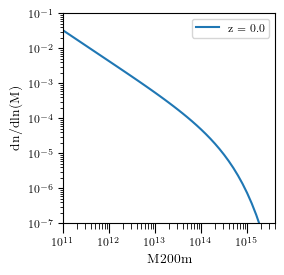

In [3]:
from colossus.lss import mass_function

z = [0.0]#, 1.0, 2.0, 4.0]
M = 10**np.arange(11.0, 15.5, 0.1)

plt.subplot(2,2,1)
plt.xlabel('M200m')
plt.ylabel('dn/dln(M)')
plt.loglog()
plt.xlim(1E11, 4E15)
plt.ylim(1E-7, 1E-1)
for i in range(len(z)):
    mfunc = mass_function.massFunction(M, z[i], mdef = '200m', model = 'tinker08', q_out = 'dndlnM')
    plt.plot(M, mfunc, '-', label = 'z = %.1f' % (z[i]))
plt.legend();

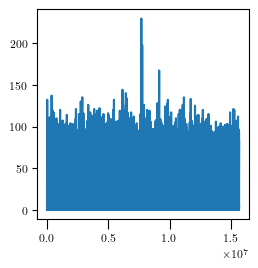

In [4]:
#assigning jackknife region
ljacks = 250
jlen = 2500/ljacks
ix = dat['x']//jlen; iy = dat['y']//jlen; iz = dat['z']//jlen

xjkreg = ix + iy*ljacks + iz*ljacks**2

uqjkregs, counts = np.unique(xjkreg, return_counts=1)
uqjkregs = uqjkregs[counts>0]
counts   = counts[counts>0]
plt.subplot(2,2,1)
plt.plot(uqjkregs , counts)

KeyboardInterrupt: 

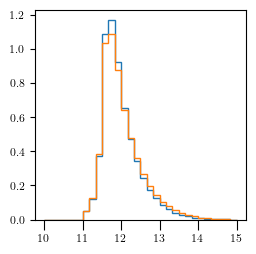

In [5]:

bins = np.linspace(10,15,31)

plt.subplot(2,2,1)
# full hmf
yy = dat['mvir']
plt.hist(np.log10(yy),weights=0.0*yy + 1/(2500)**3, bins=bins, histtype='step', density=1)
# top 25 percentile
idx = counts>np.percentile(counts,75)
yy = dat['mvir'][np.isin(xjkreg, uqjkregs[idx])]
plt.hist(np.log10(yy),weights=0.0*yy + 1/(2500)**3, bins=bins, histtype='step', density=1)
# bottom 25 percentile
idx = counts<np.percentile(counts,25)
yy = dat['mvir'][np.isin(xjkreg, uqjkregs[idx])]
plt.hist(np.log10(yy),weights=0.0*yy + 1/(2500)**3, bins=bins, histtype='step', density=1)

plt.yscale('log')


mfunc = mass_function.massFunction(10**bins, 0.0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')
plt.plot(bins, mfunc, '-', label = 'z = %.1f' % (0.0))


In [ ]:
#assigning jackknife region
ljacks = 100
jlen = 2500/ljacks
ix = dat['x']//jlen; iy = dat['y']//jlen; iz = dat['z']//jlen

xjkreg = ix + iy*ljacks + iz*ljacks**2

njacks = len(np.unique(xjkreg))
print('njacks=%d'%njacks)

nhalo = len(ix)/(2500)**3
rbins = np.logspace(np.log10(4), np.log10(20), 11)
rad   = 0.5*(rbins[:-1] + rbins[1:])

RR = 4*np.pi*(0.5*(rbins[:-1] + rbins[1:]))**2 * (rbins[1:] - rbins[:-1]) * nhalo


from scipy.spatial import cKDTree
xi = np.zeros(len(rad)*njacks)

# intrbins, x0 = jj*len(ra), x1 = (jj+1)* len(ra)
# tree on full halo catalog
htree = cKDTree(np.transpose([dat['x'], dat['y'], dat['z']]), boxsize=2500)
for jj in range(njacks):
    idx  = (xjkreg!=jj)

    jtree = cKDTree(np.transpose([dat['x'][idx], dat['y'][idx], dat['z'][idx]]), boxsize=2500)
    DD = htree.count_neighbors(jtree, rbins, cumulative=True)
    DD = np.diff(DD)/sum(idx)
    x0 = jj*len(DD); x1 = (jj+1)* len(DD)
    
    xi[x0:x1] = DD/RR - 1
    print(jj)
    

In [ ]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')
ximm = cosmo.correlationFunction(rad,0.0)
bias = np.sqrt(xi/np.tile(ximm, njacks))
#saving the bias for logMh 11 threshold
bias11 = bias.reshape((njacks, len(rad)))

yy = np.mean(bias11, axis=0)

cov     = np.zeros((len(rad),len(rad)))
for ii in range(len(rad)):
    for jj in range(len(rad)):
        cov[ii][jj] = np.mean((bias11[ii,:] - yy[ii])*(bias11[jj,:] - yy[jj]))
        cov[ii][jj] = (njacks - 1)*cov[ii][jj]



yyerr = np.sqrt(np.diag(cov))

plt.subplot(2,2,1)
plt.errorbar(rad, yy, yerr=yyerr, fmt='.', capsize=3)
plt.xlim(5.5,20)
plt.xlabel(r'$r \, [{\rm h^{-1}Mpc}]$')
plt.ylabel(r'$b_{h}$')
plt.xscale('log')    
plt.title(r'$\log[M_{\rm vir}/({\rm h^{-1}M_{\odot}})] > 11$')


In [ ]:
corr = 0.0*cov
for ii in range(len(rad)):
    for jj in range(len(rad)):
        corr[ii][jj] = cov[ii][jj]*1.0/(yyerr[ii]*yyerr[jj])


plt.subplot(2,2,1)
plt.imshow(corr,cmap='PuOr_r',vmin=-1,vmax=1,origin='lower',aspect='equal')
plt.colorbar()

Text(0, 0.5, '$\\xi(r)$')

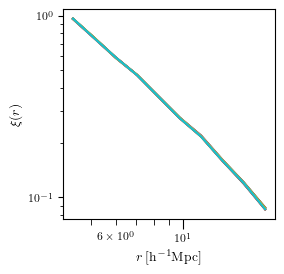

In [7]:
plt.subplot(2,2,1)
for jjx in np.random.randint(njacks, size=10):
    x0 = jjx*len(rad); x1 = (jjx+1)* len(rad)
    plt.plot(rad,xi[x0:x1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r \, [{\rm h^{-1}Mpc}]$')
plt.ylabel(r'$\xi(r)$')
